<a href="https://colab.research.google.com/github/siddharthchatterjee9/cricket/blob/main/IPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing and Cleaning Data

In [9]:
import pandas as pd
import numpy as np
from sklearn import *
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go # for data visualization
import plotly.express as px # for data visualization
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor

In [10]:
df = pd.read_csv('/ipl.csv')

# --- Data Cleaning ---
# Removing unwanted columns
columns_to_remove = ['mid', 'venue', 'batsman', 'bowler', 'striker', 'non-striker']
df.drop(labels=columns_to_remove, axis=1, inplace=True)

# Keeping only consistent teams
consistent_teams = ['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
                    'Mumbai Indians', 'Kings XI Punjab', 'Royal Challengers Bangalore',
                    'Delhi Daredevils', 'Sunrisers Hyderabad']
df = df[(df['bat_team'].isin(consistent_teams)) & (df['bowl_team'].isin(consistent_teams))]

# Removing the first 5 overs data in every match
df = df[df['overs']>=5.0]

# Converting the column 'date' from string into datetime object
from datetime import datetime
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

# --- Data Preprocessing ---
# Converting categorical features using OneHotEncoding method
encoded_df = pd.get_dummies(data=df, columns=['bat_team', 'bowl_team'])

# Rearranging the columns
encoded_df = encoded_df[['date', 'bat_team_Chennai Super Kings', 'bat_team_Delhi Daredevils', 'bat_team_Kings XI Punjab',
              'bat_team_Kolkata Knight Riders', 'bat_team_Mumbai Indians', 'bat_team_Rajasthan Royals',
              'bat_team_Royal Challengers Bangalore', 'bat_team_Sunrisers Hyderabad',
              'bowl_team_Chennai Super Kings', 'bowl_team_Delhi Daredevils', 'bowl_team_Kings XI Punjab',
              'bowl_team_Kolkata Knight Riders', 'bowl_team_Mumbai Indians', 'bowl_team_Rajasthan Royals',
              'bowl_team_Royal Challengers Bangalore', 'bowl_team_Sunrisers Hyderabad',
              'overs', 'runs', 'wickets', 'runs_last_5', 'wickets_last_5', 'total']]


#Does the database have null values?

In [11]:
encoded_df.isnull().sum()

date                                     0
bat_team_Chennai Super Kings             0
bat_team_Delhi Daredevils                0
bat_team_Kings XI Punjab                 0
bat_team_Kolkata Knight Riders           0
bat_team_Mumbai Indians                  0
bat_team_Rajasthan Royals                0
bat_team_Royal Challengers Bangalore     0
bat_team_Sunrisers Hyderabad             0
bowl_team_Chennai Super Kings            0
bowl_team_Delhi Daredevils               0
bowl_team_Kings XI Punjab                0
bowl_team_Kolkata Knight Riders          0
bowl_team_Mumbai Indians                 0
bowl_team_Rajasthan Royals               0
bowl_team_Royal Challengers Bangalore    0
bowl_team_Sunrisers Hyderabad            0
overs                                    0
runs                                     0
wickets                                  0
runs_last_5                              0
wickets_last_5                           0
total                                    0
dtype: int6

#Splitting Dataset into Training and Test

In [12]:
# Splitting the data into train and test set
X_train = encoded_df.drop(labels='total', axis=1)[encoded_df['date'].dt.year <= 2016]
X_test = encoded_df.drop(labels='total', axis=1)[encoded_df['date'].dt.year >= 2017]

y_train = encoded_df[encoded_df['date'].dt.year <= 2016]['total'].values
y_test = encoded_df[encoded_df['date'].dt.year >= 2017]['total'].values

# Removing the 'date' column
X_train.drop(labels='date', axis=True, inplace=True)
X_test.drop(labels='date', axis=True, inplace=True)


#Gradient Boosting Regression Model

In [13]:
reg = ensemble.GradientBoostingRegressor()
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 277.9533


In [14]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

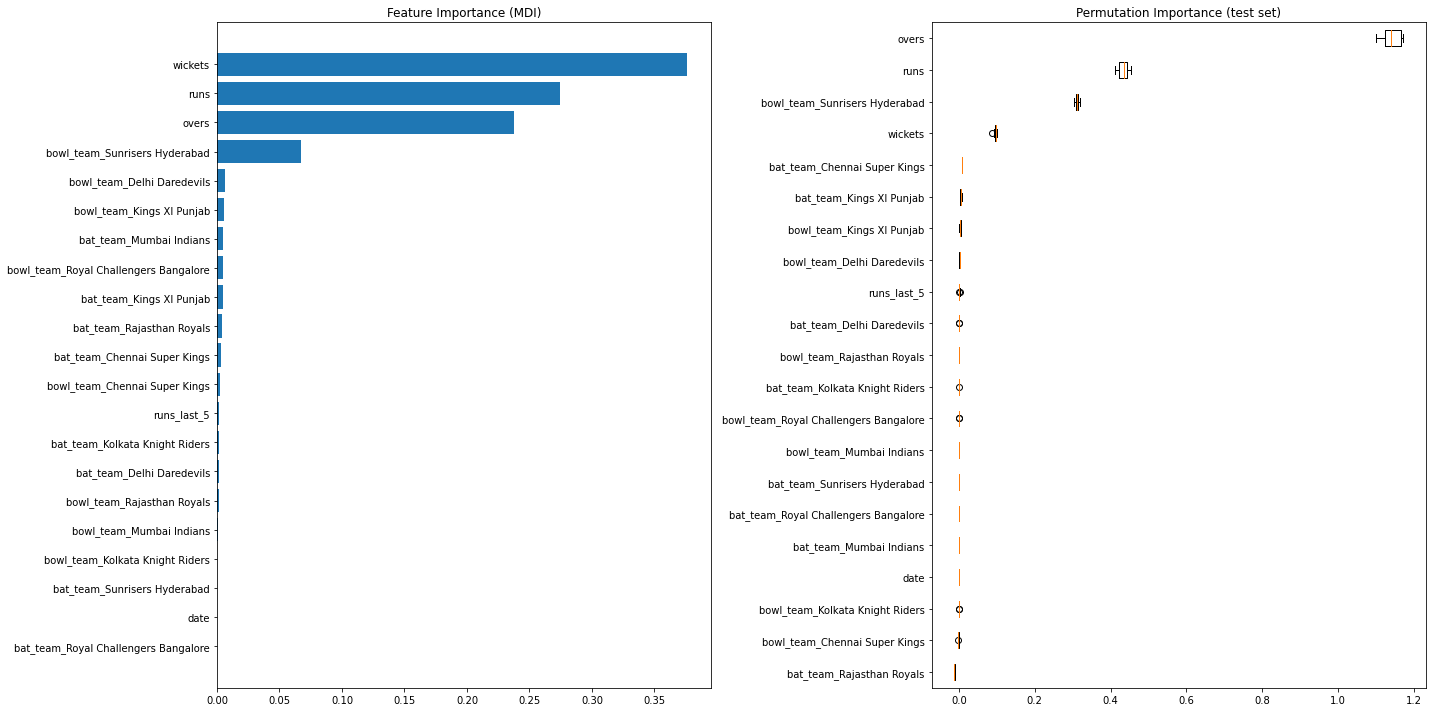

In [15]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(encoded_df.columns.tolist())[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(encoded_df.columns.tolist())[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Support Vector Regression

In [16]:
model2 = SVR(kernel='rbf', C=1, epsilon=10)
svr = model2.fit(X_test, y_test)

mse = mean_squared_error(y_test, svr.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))


The mean squared error (MSE) on test set: 643.6460


In [17]:
y_svr = model2.predict(X_test) # SVR

fig = px.scatter(encoded_df, x=encoded_df['overs'], y=encoded_df['total'], 
                 opacity=0.8, color_discrete_sequence=['black'])

model1 = LinearRegression()
lr = model1.fit(X_train, y_train)

y_lr = model1.predict(X_test)

x_range = np.linspace(encoded_df['overs'].min(), encoded_df['overs'].max(), 100)


# Add a best-fit line
fig.add_traces(go.Scatter(x=x_range, y=y_lr, name='Linear Regression', line=dict(color='limegreen')))
fig.add_traces(go.Scatter(x=x_range, y=y_svr, name='Support Vector Regression', line=dict(color='red')))
fig.add_traces(go.Scatter(x=x_range, y=y_svr+10, name='+epsilon', line=dict(color='red', dash='dot')))
fig.add_traces(go.Scatter(x=x_range, y=y_svr-10, name='-epsilon', line=dict(color='red', dash='dot')))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

# Update marker size
fig.update_traces(marker=dict(size=3))

fig.show()

# Random Forest

In [ ]:
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
Random_model = RandomForestRegressor()
Random_model.fit(X_train,y_train)

mse = mean_squared_error(y_test, Random_model.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 333.1277


# Decision Tree Regressor

In [ ]:
decision_model = DecisionTreeRegressor()
decision_model.fit(X_train,y_train)

mse = mean_squared_error(y_test, decision_model.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 525.1030


# K Nearest Neighbour

In [ ]:
knn_model = KNeighborsRegressor()
knn_model.fit(X_train,y_train)

mse = mean_squared_error(y_test, knn_model.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 401.9357


# XG Model Boost

In [18]:
xgb_model = XGBRegressor(n_estimators=390, learning_rate=0.1)
xgb_model.fit(X_test, y_test)

mse = mean_squared_error(y_test, xgb_model.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

[02:47:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The mean squared error (MSE) on test set: 13.4103


# Logistic Regression

In [19]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train,y_train)

mse = mean_squared_error(y_test, logistic_model.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 374.0371


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



# Gaussian Naive Bayes

In [20]:
NB_model = GaussianNB()
NB_model.fit(X_train,y_train)

mse = mean_squared_error(y_test, NB_model.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 1910.2541
